In [9]:
SMALL_SIZE, MEDIUM_SIZE = 9, 12
#PROJECT_PATH = "/Users/donghur/Desktop/Research/Murthy/BM_GPU"
PROJECT_PATH = "/Users/lukefoster/Documents/CompEtho/BM_GPU"
CONFIG_PATH = f"{PROJECT_PATH}/config_ant.yaml" #config_ant.yaml vs config.yaml ?

In [17]:
import sys
import numpy as np
from glob import glob
import random, matplotlib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import collections

sys.path.append(PROJECT_PATH)
from utils.data import Dataset

In [11]:
import utils.figure as ufigure
%load_ext autoreload
%autoreload 1
%aimport utils.data
%aimport utils.figure

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
Data = Dataset(PROJECT_PATH, CONFIG_PATH)
Data.load_data()

  0%|          | 0/141 [00:00<?, ?it/s]

Loading config.yaml ...
Finished loading config
Loading INFO.yaml ...
Finished loading INFO


100%|██████████| 141/141 [00:13<00:00, 10.82it/s]


In [14]:
# configuration
INFO = Data.info
INFO_values = Data.info_values
config = Data.config
skeleton = config['skeleton']
skeleton_color= config['skeleton_color']

# features
bp = Data.data_obj['bodypoints']
rot_bp = Data.data_obj['rotated_bodypoints']
angles = Data.data_obj['angles']
limbs = Data.data_obj['limbs']
angle_power = Data.data_obj['angle_power']
limb_power = Data.data_obj['limb_power']

# embeddings
all_embed = Data.data_obj['all_embeddings']
all_postural_embed = Data.data_obj['all_postural_embeddings']
all_kinematic_embed = Data.data_obj['all_kinematic_embeddings']

<hr><hr>

In [15]:
np.max(bp)

nan

In [18]:
INFO_items = list(INFO.items())
INFO_items.sort(key=lambda x: x[1]['order'])
tot_limb= []

for key, file in tqdm(INFO_items):
    save_path = file['directory']
    bp = np.load(f"{PROJECT_PATH}/{save_path}/rotated_bodypoints.npy")
    bp = bp.astype("float64")
    num_fr, num_bp, _ = bp.shape
    likelihood = bp[:,:,2]
    
    ### Locate Bad Frames ###
    # check if below likelihood threshold
    (below_thresh_fr, below_thresh_marker) = np.where(likelihood < config['likelihood_thresh'])
    cnt = collections.Counter(below_thresh_fr)
    cnt_array = np.array(list(cnt.items()))
    # check if above marker threshold
    try:
        # set low likelihood fr as bad fr
        bad_fr_idx = np.where(cnt_array[:,1] > config['marker_thresh'])[0]
        bad_fr = cnt_array[bad_fr_idx,0]
        # set nan fr as bad fr
        nan_fr, _, _ = np.where( np.isnan(bp) )
        unique_nan_fr = np.unique(nan_fr)
        bad_fr = np.concatenate([bad_fr, unique_nan_fr])
        bad_fr = np.unique(bad_fr)
        # append pads
        padded_fr = np.array([ list(range(fr-config['bad_fr_pad'], fr+config['bad_fr_pad']+1)) for fr in bad_fr])
        disregard_fr = np.unique(padded_fr.flatten())
        disregard_fr = disregard_fr[(disregard_fr >= 0) & (disregard_fr < num_fr)]
        good_fr_idx = np.array([True]*num_fr)
        good_fr_idx[disregard_fr] = False
        good_fr = np.where(good_fr_idx==True)[0]
    except:
        bad_fr = np.array([])
        disregard_fr = np.array([])
        good_fr = np.arange(num_fr)

    # TODO: modify proportion of good fr
    file['good_fr'] = good_fr.tolist()
    file['bad_fr'] = bad_fr.tolist()
    file['disregard_fr'] = disregard_fr.tolist()
    
    
    # ********* fix ***********
    limbs = np.zeros((num_fr, len(config['limbs'])))
    for i, limb_pts in enumerate(config['limbs']):
        bp_good_fr = bp[good_fr,:,:]

        limb_i = bp_good_fr[:,limb_pts,:]
        
        limbs[good_fr,i] = np.sqrt((limb_i[:,0,0]-limb_i[:,1,0])**2 + (limb_i[:,0,1]-limb_i[:,1,1])**2)
    inf_fr,_ = np.where(np.isinf(limbs))
    if len(inf_fr) != 0:
        break

        
#     tot_limb.append(limbs[good_fr,:])

In [19]:
num_fr,_,_ = rot_bp.shape

nan_fr,_,_ = np.where(np.isnan(rot_bp))
nan_fr = np.unique(nan_fr)
good_fr = np.array([True]*num_fr)
good_fr[nan_fr] = False

np.max(rot_bp[good_fr,:,:])

155.8

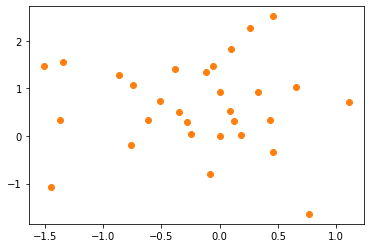

In [20]:
plt.scatter(bp[100,:,0], bp[100,:,1])
plt.scatter(rot_bp[100,:,0], rot_bp[100,:,1])
plt.show()

In [21]:
np.sqrt(np.sum((rot_bp[200,1,:]-rot_bp[200,2,:])**2))

1.036